### Read in packages


In [215]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import Word, TextBlob
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yangsun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yangsun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yangsun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Define functions

In [217]:
def read_data(url:str):
    """read in data from a url
    """
    return pd.read_csv(url).iloc[:,0:2]

def add_col(dataset, colname:str, newcolname:str, function)->None:
  dataset[newcolname] = dataset[colname].apply(function)
  return None

def word_count(review_str)->int:
  """ count number of words in a string of reviews
  """
  return len(review_str.split())


def stopword_count(review_str:str)->int:
  """count number of stop words on a string
  """
  # load list of stop words
  from nltk.corpus import stopwords
  stop_words = stopwords.words("english")
  return len([word for word in review_str.split() if word.lower() in stop_words])


def lower_case(review_str:str)->str:
  """lower case a review string
  """
  return " ".join(word.lower() for word in review_str.split())


def remove_puncatuation(review_str:str)->str:
  """remove puncatuation of a string
  """
  import re
  return re.sub(r'[^\w\s]', '', review_str) 


def remove_length10_word(review_str:str)->str:
  """remove any words have length more than 10 on str
  """
  final_list =[]
  for word in review_str.split():
    if len(word)<10:
      final_list.append(word)
  
  return " ".join(final_list)


def average_word_length(word_list)->int:
    """calculate the average word length in each review
    """
    word_length = []
    for word in word_list.split(): 
        word_length.append(len(word))
    return np.mean(word_length)

def remove_stop_word(review_str:str)->str:
  """remove stop words from a string
  """
  from nltk.corpus import stopwords
  stopwords = stopwords.words("english")
  return " ".join(word for word in review_str.split() if word not in stopwords)

def lemmatize(review_str:str)->str:
    return " ".join(Word(word).lemmatize(pos="v") for word in review_str.split())

def get_polarity(review_str:str)->str:
    return TextBlob(remove_stop_word(remove_length10_word(remove_puncatuation(lower_case(review_str))))).sentiment[0]



### Read in data

In [218]:
url ="https://usc-bootcamp-yelpreview-text-analysis.s3.us-east-2.amazonaws.com/reviews.csv"
reviews = read_data(url)
reviews.head()

,reviews,rating
0,Panda Express was on point tonight! I ordered ...,5 star rating
1,The dude and I came to this Panda Express arou...,5 star rating
2,"I ordered 5 total plates , fried rice , chow m...",1 star rating
3,I always order Panda Express from here and the...,3 star rating
4,"I've never had a bad experience here, I don't ...",4 star rating


### Adding more features & Clean up the data

In [219]:
add_col(reviews, "reviews", "word_count", word_count)
add_col(reviews, "reviews", "stop_word_count", stopword_count)

reviews["stop_word_percent"] = reviews["stop_word_count"]/reviews["word_count"]

add_col(reviews, "reviews", "lowercase_reviews", lower_case)
add_col(reviews, "lowercase_reviews", "remove_puncatuation", remove_puncatuation)
add_col(reviews, "remove_puncatuation", "remove_length10_word", remove_length10_word)
add_col(reviews, "remove_length10_word", "word_length", average_word_length)
add_col(reviews, "remove_length10_word", "clean_reviews", remove_stop_word)

final_dataset = reviews.loc[:,["rating","word_count","stop_word_percent","word_length", "clean_reviews"]]
final_dataset.head()

,rating,word_count,stop_word_percent,word_length,clean_reviews
0,5 star rating,63,0.444444,4.032258,panda express point tonight ordered mobile app...
1,5 star rating,149,0.463087,3.952055,dude came panda express around end july 2020 h...
2,1 star rating,30,0.266667,4.407407,ordered 5 total plates fried rice chow main do...
3,3 star rating,122,0.467213,4.008333,always order panda express problem ever place ...
4,4 star rating,120,0.483333,3.930435,ive never bad dont 212 stars reading reviews s...


### Exploratory Data Analysis

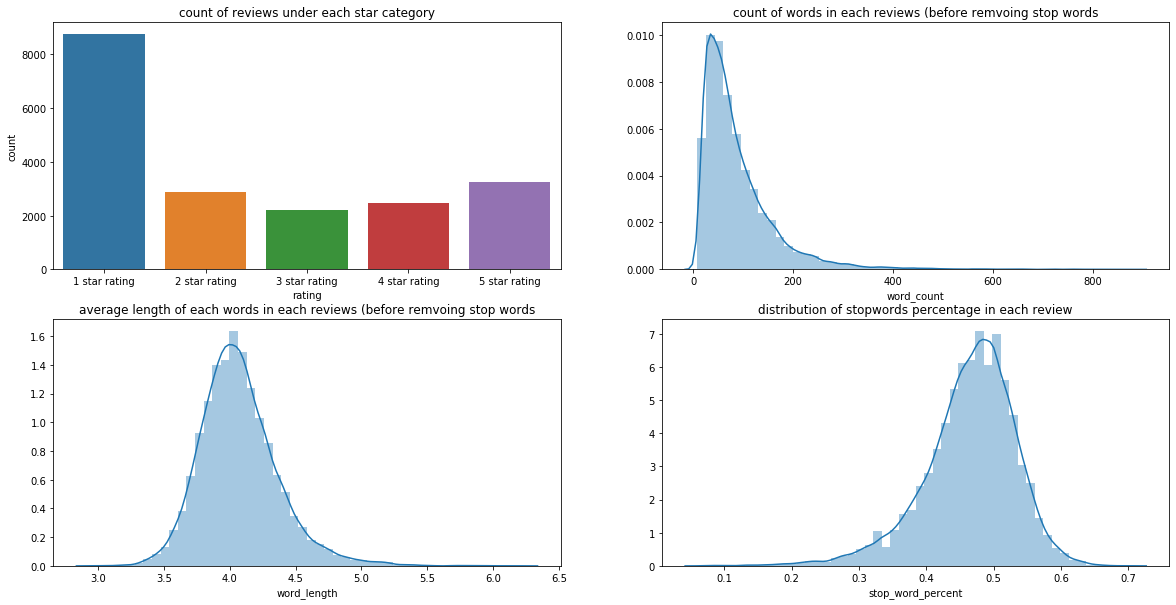

In [221]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2,figsize = (20,10))

# order the star label
label_order = ["1 star rating", "2 star rating","3 star rating","4 star rating","5 star rating"]

sns.countplot(data = final_dataset, x="rating", ax=ax1, order = label_order).set(title = "count of reviews under each star category")
sns.distplot(final_dataset["word_count"], ax = ax2).set(title = "count of words in each reviews (before remvoing stop words")
sns.distplot(final_dataset["word_length"], ax = ax3).set(title = "average length of each words in each reviews (before remvoing stop words")
sns.distplot(final_dataset["stop_word_percent"], ax = ax4).set(title = "distribution of stopwords percentage in each review")
plt.show()

- The dataset has too many 1 star rating review
- Total number of words in each review is right skewed, but overall, most of the reviews have about 10 - 200 words in each review
- After removing word which has more then 10 characters in it, the word length is normally distributed. 
- The stop words in each review is a little but left skewed. 

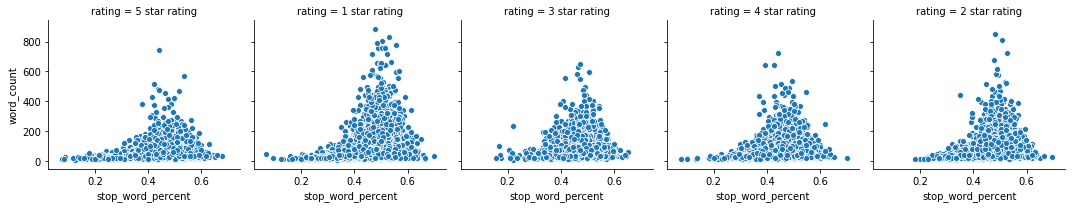

In [222]:
# look at some relationship between variables
g = sns.FacetGrid(final_dataset,col = "rating")
g.map(sns.scatterplot, "stop_word_percent","word_count")
g.add_legend()
plt.show()


- Does not seem a relationship between stop word percentage and word count of each review

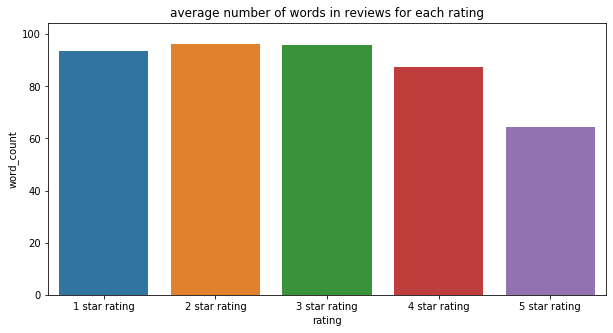

In [223]:
plt.figure(figsize = (10,5))
sns.barplot(data = final_dataset, x = "rating", y = "word_count", order = label_order,errwidth=False).set(title = "average number of words in reviews for each rating")
plt.show()

- For people who give 5 stars, they tend to write less words in their reviews. Unless 5 star reviews, people who give 1 - 2 star reviews, they tend to write more words. 


### Lemmatization


In [224]:
# add a lemmatized column based on clean_review
add_col(final_dataset, "clean_reviews", "lemmatized_reviews", lemmatize)
final_dataset.head()

,rating,word_count,stop_word_percent,word_length,clean_reviews,lemmatized_reviews
0,5 star rating,63,0.444444,4.032258,panda express point tonight ordered mobile app...,panda express point tonight order mobile app p...
1,5 star rating,149,0.463087,3.952055,dude came panda express around end july 2020 h...,dude come panda express around end july 2020 h...
2,1 star rating,30,0.266667,4.407407,ordered 5 total plates fried rice chow main do...,order 5 total plat fry rice chow main double o...
3,3 star rating,122,0.467213,4.008333,always order panda express problem ever place ...,always order panda express problem ever place ...
4,4 star rating,120,0.483333,3.930435,ive never bad dont 212 stars reading reviews s...,ive never bad dont 212 star read review see mi...


### Calculate sentiment (polarity and subjectivity)

In [225]:
final_dataset["polarity"] = final_dataset["lemmatized_reviews"].apply(lambda x: TextBlob(x).sentiment[0])
final_dataset["subjecitivity"] = final_dataset["lemmatized_reviews"].apply(lambda x: TextBlob(x).sentiment[1])
final_dataset.head()


,rating,word_count,stop_word_percent,word_length,clean_reviews,lemmatized_reviews,polarity,subjecitivity
0,5 star rating,63,0.444444,4.032258,panda express point tonight ordered mobile app...,panda express point tonight order mobile app p...,0.392857,0.464286
1,5 star rating,149,0.463087,3.952055,dude came panda express around end july 2020 h...,dude come panda express around end july 2020 h...,0.048708,0.492424
2,1 star rating,30,0.266667,4.407407,ordered 5 total plates fried rice chow main do...,order 5 total plat fry rice chow main double o...,-0.108333,0.508333
3,3 star rating,122,0.467213,4.008333,always order panda express problem ever place ...,always order panda express problem ever place ...,-0.264000,0.584000
4,4 star rating,120,0.483333,3.930435,ive never bad dont 212 stars reading reviews s...,ive never bad dont 212 star read review see mi...,0.262879,0.422511


- Polarity: sentiment is the review (positive or negative). It ranges from -1 to 1, and -1 means very negative, 1 means very positive.
- Subjectivity: How factual of each review. It uses to maeasure how much personal opinion is in each review. Number ranges from 0 - 1. 

### Dive deeper into the finaldata

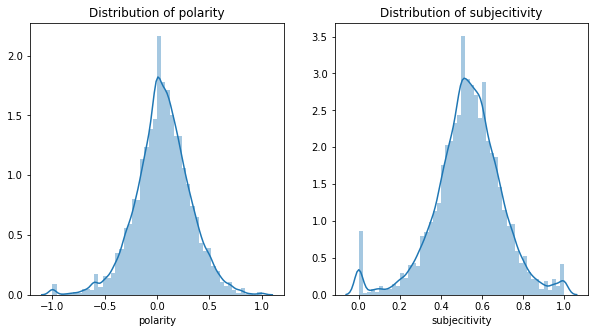

In [226]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (10,5))
sns.distplot(final_dataset["polarity"], ax = ax1).set(title = "Distribution of polarity")
sns.distplot(final_dataset["subjecitivity"], ax = ax2).set(title = "Distribution of subjecitivity")
plt.show()

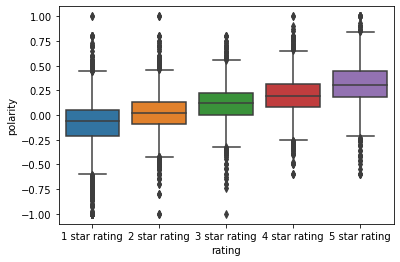

In [227]:
sns.boxplot(data = final_dataset, x = "rating", y = "polarity", order = label_order)
plt.show()

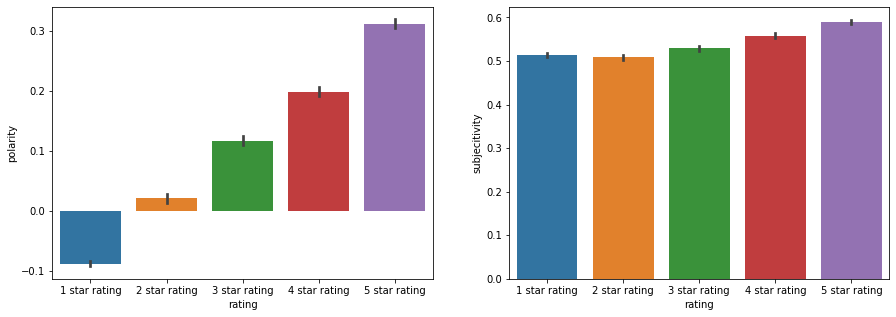

In [228]:
# each metric with respect to rating
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (15,5))

label_order = ["1 star rating", "2 star rating","3 star rating","4 star rating","5 star rating"]
sns.barplot(data = final_dataset, x = "rating", y = "polarity", order = label_order, ax= ax1)
sns.barplot(data = final_dataset, x = "rating", y = "subjecitivity", order = label_order, ax= ax2)
plt.show()

- The polarity score seems to be a good measure for the reviews for each rating. 1 star has negative polarity score, and as star increases, the polarity scores increases also. 
- Subjecitivity does not seem to have a relationship with star rating. Meaning people's subjecivity of their reviews is same when they give ratings.

### Conculsion

- Textblob seems to be a good tool to measure the sentiment of reivews, and it can be used for customer reviews which have no classification of whether is positive or negative. 
- The sentiment of each review gives people a quantative perspective of what customer says, and it reduces the bias when people judge each feedback.